# Bortezomib and Lenalidomide Ikaros, Aiolos, and Helios MFI analysis

To examine the effects of bortezomib and lenalidomide on the Ikaros-family transcription factors Ikaros, Aiolos, and Helios, we isolated T cells from PBMCs obtained from five healthy adult subjects, then treated these cells with a DMSO-only control, bortezomib, lenalidomide, or both drugs together. At 24 and 48 hours post-treatment, we collected cells and performed intracellular antibody staining for the 3 transcription factors. We also stained with a panel of antibodies that can be used to gate specific T cell subpopulations: CD4 Naive, CD4 CM, CD4 EM, CD4 TEMRA (not many), CD4 Treg, CD8 Naive, CD8 CM, CD8 EM, and CD8 TEMRA cells. After gating, mean fluorescense intensity values were calculated for each cell population at each time point under each treatment condition using FlowJo.

In this notebook, we'll perform statistical tests on the MFI values to compare DMSO-only to each treatment condition. As the same subjects were used for control and treatment conditions, we'll use paired T-tests and correct for multiple hypotheses using the Benjamini and Hochberg False Discovery Rate method.

## Load packages

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(dplyr)
quiet_library(ggplot2)

In [2]:
if(!dir.exists("output")) { dir.create("output") }

In [3]:
mfi <- read.csv("data/bor-len_combin_Ikaros-Aiolos-Helios_mfi.csv")

In [4]:
mfi_fc <- mfi %>%
  group_by(subject, timepoint, population, target) %>%
  mutate(fc = mfi / mfi[treatment == "dmso"]) %>%
  mutate(logFC = log2(fc)) %>%
  ungroup()

In [5]:
mfi_tests <- mfi_fc %>%
  group_by(subject, timepoint, population, target) %>%
  mutate(dmso_mfi = mfi[treatment == "dmso"],
         bg_treatment = "dmso",
         bg_timepoint = timepoint) %>%
  filter(treatment != "dmso") %>%
  group_by(treatment, timepoint, bg_treatment, bg_timepoint, population, target) %>%
  summarise(nomP = t.test(mfi, dmso_mfi, paired = TRUE, alternative = "two.sided")$p.value,
            mean_mfi = mean(mfi),
            sd_mfi = sd(mfi),
            max_mfi = max(mfi),
            mean_lfc = mean(logFC),
            max_lfc = max(logFC),
            .groups = "keep") %>%
  mutate(adjP = p.adjust(nomP, method = "BH"))

In [6]:
head(mfi_tests)

treatment,timepoint,bg_treatment,bg_timepoint,population,target,nomP,mean_mfi,sd_mfi,max_mfi,mean_lfc,max_lfc,adjP
<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
bor,24,dmso,24,t_cd4_cm,Aiolos,0.06906414,17905.4,3405.1824,22449,0.57658570,1.1251793,0.06906414
bor,24,dmso,24,t_cd4_cm,Helios,0.02302320,1146.4,422.2213,1647,0.34285045,0.6118981,0.02302320
bor,24,dmso,24,t_cd4_cm,Ikaros,0.81529158,63447.0,4559.8583,68949,0.03367400,0.2126214,0.81529158
bor,24,dmso,24,t_cd4_em,Aiolos,0.10155880,22916.4,8003.6662,35727,0.42360158,1.0248041,0.10155880
bor,24,dmso,24,t_cd4_em,Helios,0.11312506,995.0,206.4788,1273,0.23860939,0.6953865,0.11312506
bor,24,dmso,24,t_cd4_em,Ikaros,0.45445493,65132.4,14307.3668,89113,-0.08237127,0.2775900,0.45445493


Let's make a quick heatmap to check out these results:

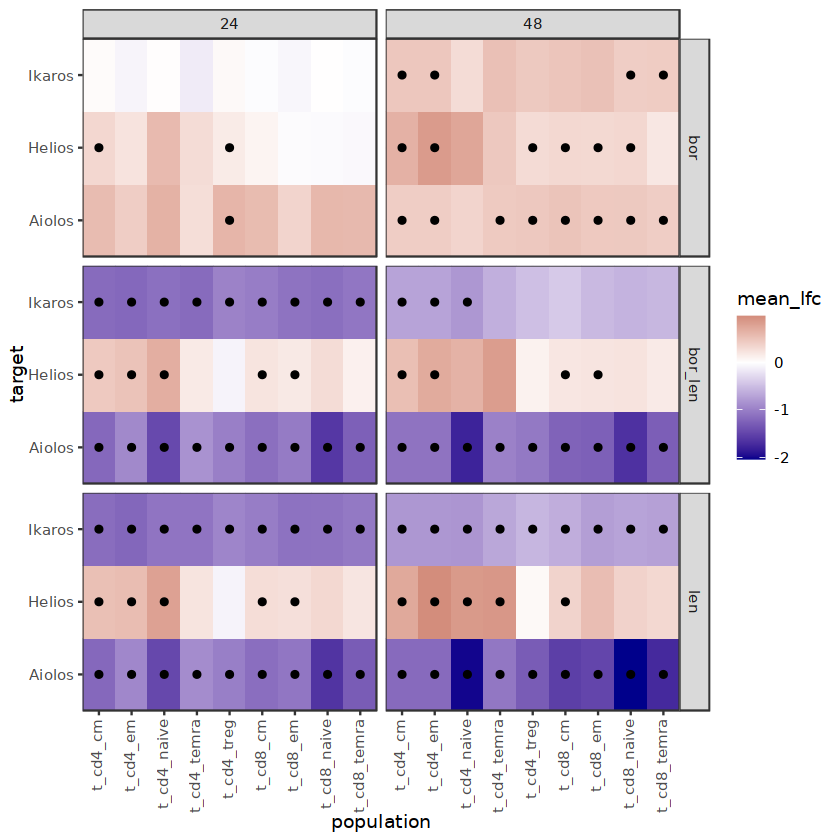

In [7]:
sig_tests <- mfi_tests %>%
  filter(adjP < 0.05)

ggplot() +
  geom_tile(
      data = mfi_tests,
      aes(x = population,
          y = target,
          fill = mean_lfc)
  ) +
  geom_point(
      data = sig_tests,
      aes(x = population,
          y = target),
      color = "black"
  ) +
  scale_fill_gradient2(
      low = "darkblue",
      mid = "white",
      high = "darkred",
      midpoint = 0
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  facet_grid(
      cols = vars(timepoint),
      rows = vars(treatment)
  ) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

We should also test whether the baseline (DMSO) changes between the two timepoints.

In [8]:
dmso_fc <- mfi %>%
  filter(treatment == "dmso") %>%
  group_by(subject, population, target) %>%
  mutate(fc = mfi / mfi[timepoint == 24]) %>%
  mutate(logFC = log2(fc)) %>%
  ungroup()

In [9]:
dmso_tests <- dmso_fc %>%
  group_by(subject, population, target) %>%
  mutate(bg_mfi = mfi[timepoint == 24],
         bg_treatment = "dmso",
         bg_timepoint = 24) %>%
  filter(timepoint != 24) %>%
  group_by(treatment, timepoint, bg_treatment, bg_timepoint, population, target) %>%
  summarise(nomP = t.test(mfi, bg_mfi, paired = TRUE, alternative = "two.sided")$p.value,
            mean_mfi = mean(mfi),
            sd_mfi = sd(mfi),
            max_mfi = max(mfi),
            mean_lfc = mean(logFC),
            max_lfc = max(logFC),
            .groups = "keep") %>%
  mutate(adjP = p.adjust(nomP, method = "BH"))

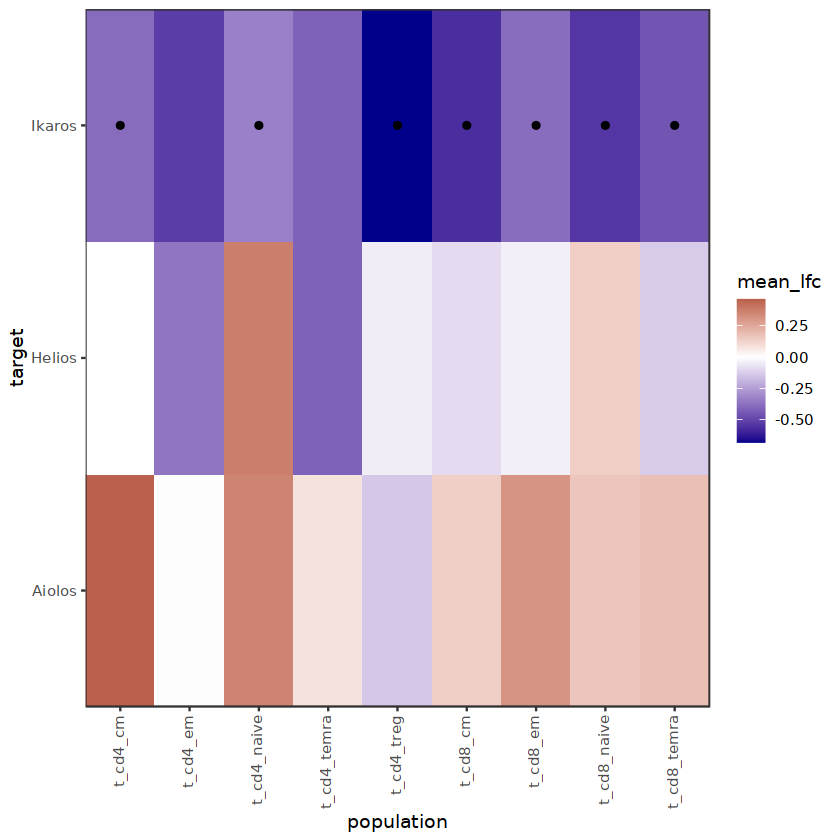

In [10]:
sig_tests <- dmso_tests %>%
  filter(adjP < 0.05)

ggplot() +
  geom_tile(
      data = dmso_tests,
      aes(x = population,
          y = target,
          fill = mean_lfc)
  ) +
  geom_point(
      data = sig_tests,
      aes(x = population,
          y = target),
      color = "black"
  ) +
  scale_fill_gradient2(
      low = "darkblue",
      mid = "white",
      high = "darkred",
      midpoint = 0
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

So, Ikaros decreases significantly between the two time points in some cell types.

For use in figures, we'll assemble both the DMSO and drug treatment results into a single table.

In [11]:
all_tests <- rbind(mfi_tests, dmso_tests)

In [12]:
write.csv(
    all_tests,
    "output/bor-len_combin_Ikaros-Aiolos-Helios_mfi_stats.csv",
    quote = FALSE, row.names = FALSE
)

In [13]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.3 dplyr_1.1.3  

loaded via a namespace (and not attached):
 [1] crayon_1.5.2     vctrs_0.6.3      cli_3.6.1        rlang_1.1.1     
 [5] generics_0.1.3   Cairo_1.6-1      jsonlite_1.8.7   labeling_0.4.3  
 [9] glue_1.6.2       colorspace_2.1-0 htmltools_0.5.6  IRdisplay_1.1   
[13] IRkernel_1.3.